# Oil spill mapping using Sentinel-1

Several advanced techniques have been discussed and presented by researchers; however, in this notebook, we want to showcase a basic methodology for mapping oil spills using openEO.

Though openEO is fully capable of executing advanced workflows, our focus here is to show a simple yet effective method. This notebook was inspired by the algorithm shown [here](https://github.com/senbox-org/s1tbx/blob/master/s1tbx-op-feature-extraction/src/main/java/org/esa/s1tbx/fex/gpf/oceantools/OilSpillDetectionOp.java).

Additionally, the following references were equally helpful when preparing this usecase:

* https://forum.step.esa.int/t/steps-for-oil-spill-detection/7428/6
* https://ieeexplore.ieee.org/document/1370264

In [2]:
# Load the essentials
import openeo
from openeo.processes import log
import numpy as np

In [3]:
connection = openeo.connect("openeo.dataspace.copernicus.eu").authenticate_oidc()

Authenticated using refresh token.


For this workflow, our area of interest is the southern coast of Kuwait near the resort community of Al Khiran, where an oil spill was reported in 2017.

https://skytruth.org/2017/08/satellite-imagery-reveals-scope-of-last-weeks-massive-oil-spill-in-kuwait/

In [5]:
aoi = {
    "type": "Polygon",
    "coordinates": [
        [
            [48.325487506118264, 28.742803969343313],
            [48.325487506118264, 28.414218984218607],
            [48.75387693420447, 28.414218984218607],
            [48.75387693420447, 28.742803969343313],
            [48.325487506118264, 28.742803969343313],
        ]
    ],
}

In [6]:
s1_image = connection.load_collection(
    "SENTINEL1_GRD",
    temporal_extent=["2017-08-09", "2017-08-12"],
    spatial_extent=aoi,
    bands=["VV"],
)

s1_image = s1_image.sar_backscatter(coefficient="sigma0-ellipsoid")

Usually the distribution of SAR backscatter values is too heavy tailed and difficult to analyse (visually and numerically). Therefore let's normalize the backscatter values by Log with base 10. For further information See https://forum.step.esa.int/t/sigma0-vh-vs-sigma0-vhdb/2661?u=abraun

In [7]:
s1_image = s1_image.apply(process=lambda data: 10 * log(data, base=10))

Now let us define the adaptive thresholding. It is a two-step process where we first identify the mean value within a window and then select anything below the mean of that threshold.

In [8]:
filter_window = (np.ones([601, 601])).tolist()

In [9]:
# calculate factor
factor = 1 / 361201

In [10]:
thresholds = s1_image.apply_kernel(kernel=filter_window, factor=factor)

In [11]:
threshold_shift = 3.5
thresholds = thresholds - threshold_shift
thresholds = thresholds.rename_labels(dimension="bands", target=["threshold"])

In the above cell, we selected the threshold based on the https://eo4society.esa.int/wp-content/uploads/2022/01/OCEA03_OilSpill_Kuwait.pdf and it can be changed to any value based on the requirements.

Now we have a separate datacube with the threshold for the entire study area. Let us compare it with our Sentinel-1 datacube. But before that, to have similar properties, we are renaming the amplitude bands and applying the `merge_cube` process. 

In [12]:
s1_image = s1_image.rename_labels(dimension="bands", target=["amplitude"])
s1_image = s1_image.merge_cubes(thresholds)
oil_spill = s1_image.band("amplitude") < s1_image.band("threshold")

In [13]:
# execute the workflow
oil_spill.execute_batch(title="Oil Spill Data", outputfile="OilSpill.nc")

0:00:00 Job 'j-240201efd74f4a12a1bfd8bb532b2de1': send 'start'
0:00:25 Job 'j-240201efd74f4a12a1bfd8bb532b2de1': created (progress N/A)
0:00:33 Job 'j-240201efd74f4a12a1bfd8bb532b2de1': created (progress N/A)
0:00:48 Job 'j-240201efd74f4a12a1bfd8bb532b2de1': created (progress N/A)
0:00:58 Job 'j-240201efd74f4a12a1bfd8bb532b2de1': created (progress N/A)
0:01:10 Job 'j-240201efd74f4a12a1bfd8bb532b2de1': created (progress N/A)
0:01:24 Job 'j-240201efd74f4a12a1bfd8bb532b2de1': running (progress N/A)
0:01:40 Job 'j-240201efd74f4a12a1bfd8bb532b2de1': running (progress N/A)
0:02:02 Job 'j-240201efd74f4a12a1bfd8bb532b2de1': running (progress N/A)
0:02:27 Job 'j-240201efd74f4a12a1bfd8bb532b2de1': running (progress N/A)
0:03:02 Job 'j-240201efd74f4a12a1bfd8bb532b2de1': running (progress N/A)
0:03:44 Job 'j-240201efd74f4a12a1bfd8bb532b2de1': running (progress N/A)
0:04:33 Job 'j-240201efd74f4a12a1bfd8bb532b2de1': running (progress N/A)
0:06:55 Job 'j-240201efd74f4a12a1bfd8bb532b2de1': running (pr

<BatchJob job_id='j-240201efd74f4a12a1bfd8bb532b2de1'>

## Let us plot the result

In [1]:
import matplotlib.pyplot as plt
import xarray as xr

In [2]:
oilspill = xr.load_dataset("OilSpill.nc")

In [3]:
data = oilspill[["var"]].to_array(dim="bands")

Text(0.5, 1.0, 'Oil Spill Image')

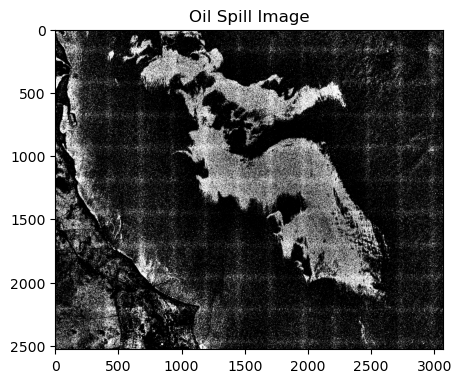

In [8]:
oilspill_array = data.squeeze().values[600:-600, 600:-600]
fig, axes = plt.subplots(ncols=1, figsize=(5, 5), dpi=100)
axes.imshow(oilspill_array, vmin=0, vmax=1, cmap=plt.cm.gray)
axes.set_title("Oil Spill Image")

If we compare with the available manually mapped ground truth shown in the image below, we can conclude that our workflow effectively showed the oil spill in the selected area of interest.

<img src="gt.png" style="width:50%;">)